In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

In [5]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [26]:
data = pd.read_csv('Data/CleanedCovidData10-8.csv')

There are a few features that should not be included. These are the features that have been encoded into dummy variables. They are still in the data set in order to support visualizations in the EDA file, but are not necessary for any of the machine learning models.

In [28]:
variables_not_include = ['Entity of Birth Grouped','Entity of Residence Grouped','Entity Location Grouped','Test Result','Date of Death',
                        'Sympton Onset','Admission Date','Type of Care','Entity of Birth','Entity of Residence','Entity Location',
                        'Sex','Sector','Origin','Record ID','Update Date','Unnamed: 0']
for var in variables_not_include:
    del data[var]

I am creating the training data set here. I am holding out only 5% of the data for testing. I think that 5% will be enough considering the cleaned data contains 696,781 observations. This will allow for 34,839 observations to be used as test data, which seems like plenty.

In [30]:
X_train, X_test = train_test_split(data, test_size = 0.05,random_state=10082020)

Assigning the target variable to y, and the rest of the variables to X.

In [31]:
p_variables = list(X_train.columns)
p_variables.remove('Died')
X = X_train[p_variables]
y = X_train['Died']

In [32]:
def forwardSelection(X,y,model,factor):
    """This function goes and does forward selection using the X and y arrays passed in as well as the model to fit
    the data to. Also takes in which factor to use for model selection. Returns a list containing model from each addition 
    of next most useful feature."""
    predictors = list(X.columns)
    remaining_predictors = list(X.columns)
    factor_values = []
    feature_additions = [[]]

    for i in range(len(predictors)):
        max_factor = -999999999999999
        best_feature = ""
        for feature in remaining_predictors:
            features_to_use = list(feature_additions[-1])
            features_to_use.append(feature)
            model.fit(X[features_to_use],y)
            if factor == 'Deviance':
                #Deviance is -2* log likelihood estimate for model. Sklearn returns the negative of the log likelihood estimate
                #so I would need to multiply by +2. Except since I want to minimize this, but if the wanted comparison is with
                #Rate, then we would want to maximize, I will multiply by -2 so that capturing the maximum of the - vaue
                #will be the minimum of the + value
                f = -2*metrics.log_loss(y, model.predict_proba(X[features_to_use]), normalize=False)
            #if the factor to use is Rate, then that means to use classification accuracy score
            elif factor == 'Rate':
                f = model.score(X[features_to_use],y)
            if f > max_factor:
                max_factor = f
                best_feature = feature
                
        next_model = list(feature_additions[-1])
        next_model.append(best_feature)
        feature_additions.append(next_model)
        factor_values.append(max_factor)
        remaining_predictors.remove(best_feature)
        
    return feature_additions, factor_values

In [33]:
def performValidations(X,y,variable_sets,folds,model):
    """Function takes in the X and y arrays and also takes in the stepwise models at each step of forward stepwise
    selection. Also takes in how many folds to do with K-fold and which model data should be fitted on"""
    cv = KFold(n_splits=folds, random_state=1, shuffle=True)
    #loop through each set and perform k-fold cross validation for each  model, then report the average classification rate
    mean_accuracies = []
    std_accuracies = []
    for sett in variable_sets:
        scores = cross_val_score(model, X[sett], y, scoring='accuracy', cv=cv, n_jobs=-1)
        mean_accuracies.append(scores.mean())
        std_accuracies.append(scores.std())
    return mean_accuracies, std_accuracies

# Logistic Regression

## Performing Forward Stepwise Selection of Variables

In [34]:
log_model = LogisticRegression(penalty = 'none', max_iter= 10000)
features, factors = forwardSelection(X,y,log_model,'Deviance')

The cell above took multiple hours to run, so below I am writing the output to a csv file so I don't have to run the above cell again.

In [46]:
output_lines = []
for feature in features:
    line = "Features ["
    for item in feature:
        line += str(item)
        line += ","
    line += "]"
    output_lines.append(line)

output_df = pd.DataFrame({'features':output_lines[1:],'factors':factors})
output_df.to_csv('ForwardSelectionResults.csv')

Below is a plot of the Deviance (comparable to MSE or R-squared for Regression problems)

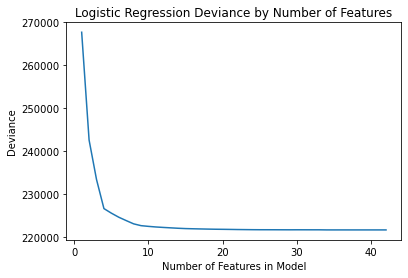

In [92]:
fwdselection = pd.read_csv('ForwardSelectionResults.csv')
#in order to be maximizing this factor in the forward stepwise selection function, I had to make this negative. I am turning it positive again
fwd_deviance = -1*fwdselection['factors']
num_fwd_features = fwdselection['features']

plt.plot(np.arange(1,len(num_fwd_features)),fwd_deviance[1:])
plt.title("Logistic Regression Deviance by Number of Features")
plt.xlabel("Number of Features in Model")
plt.ylabel("Deviance")
#plt.savefig("Forward Selection Deviance.png")

This shows me that after 10 factors are included, the estimated test error doesn't really get any better. The model with 10 features is shown below.

In [94]:
num_fwd_features[9]

'Features [Care_1,Intubation Required,Age,Pneumonia,Sector_4,Kidney Failure,Sex_2,Diabetes,Sector_9,Obesity,]'

Below shows performing 10-fold cross validation for each model and the resulting estimated test accuracy for each model. This agrees with the deviance plot above, showing the accuracy does not increase after the model has 10 features.

In [52]:
means, stds = performValidations(X,y,features,10,log_model)

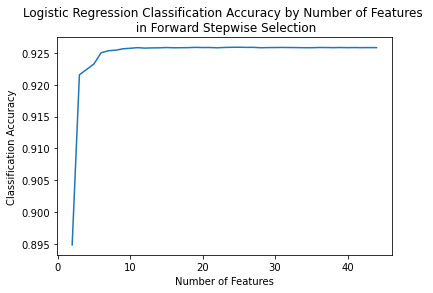

In [104]:
plt.plot(np.arange(1,45,1),means)
plt.title("Logistic Regression Classification Accuracy by Number of Features \n in Forward Stepwise Selection")
plt.xlabel("Number of Features")
plt.ylabel("Classification Accuracy")
#plt.savefig('Forward Selection Accuracy.png')

## Performing Backward Stepwise Selection of Variables

In [51]:
from sklearn.feature_selection import RFE
selector = RFE(log_model,n_features_to_select=12,step=1)
selector = selector.fit(X,y)

[ True  True False  True False False False False  True False False False
 False False False False  True False  True  True False  True False  True
 False False False False False False  True False  True  True False False
 False False False False False False False]
[ 1  1 28  1  7  2 19 24  1 22 30 27  4 26 17 31  1 25  1  1 29  1 15  1
 16  3 32 21  5  6  1 11  1  1  8  9 10 23 18 20 13 12 14]


This above cell took quite some time to run too, so I am writing the output to a file too so I don't need to run it again.

In [66]:
backward_selection_df = pd.DataFrame({"Feature":list(X.columns),"Selected":list(selector.support_),"Ranking":list(selector.ranking_)})
backward_selection_df.to_csv('BackwardSelectionoutput.csv')

The below cell performs the backward selection, but only one step at a time instead of doing all the steps in one line of code. This cell captures the models at each step.

In [72]:
bwdselection = pd.read_csv('BackwardSelectionoutput.csv')
bwd_selected = bwdselection['Selected']

variables = list(X.columns[bwd_selected])
models = [[]]
for i in range(12):
    models.append(variables)
    selector2 = RFE(log_model,n_features_to_select=12-i,step=1)
    selector2 = selector2.fit(X[variables],y)
    variables = list(pd.Series(variables)[selector2.support_])

The cell below uses the models created along each step of backward selection and does 10-Fold cross validation and records the mean accuracy for each model over the 10-folds.

In [74]:
back_means, back_stds = performValidations(X,y,models,10,log_model)

Below plots the accuracy of the model as a function of how many features are involved.

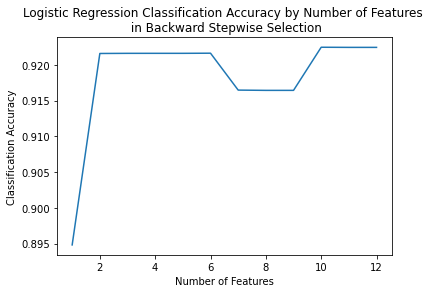

In [102]:
x_axis_nums = []
for i in range(12):
    x_axis_nums.append(12-i)
    
plt.plot(x_axis_nums,back_means[1:])
plt.title("Logistic Regression Classification Accuracy by Number of Features \n in Backward Stepwise Selection")
plt.xlabel("Number of Features")
plt.ylabel("Classification Accuracy")
#plt.savefig("Backward Selection Accuracy.png")

This seems odd that there is a raise in accuracy after dropping 2 features from the model that has 7 features. However, despite this, the maximum classification accuracy occurs when having 10 features. The model that uses 10 features is shown below.

In [98]:
print(models[4])

['Intubation Required', 'Pneumonia', 'Pregnant', 'Sector_2', 'Sector_4', 'Sector_7', 'Sector_9', 'Care_1', 'Origin_1', 'Origin_2']


## Performing L2 Regularization

In [81]:
#first need to standardize the age feature
age_normal = list(X['Age'])
age_standardized = list(X['Age']/X['Age'].std())
X['Age'] = age_standardized
#I want to keep track of the coefficients, mean accuracies and the standard deviations
coefficients = []
mean_accuracies = []
std_accuracies = []
#I want to loop through a range of values with a broad step of 2, and if there appears to be a place where I need
#a higher granularity I will approach only a small section with the small granularity instead of the whole region
for c in range(-11,11,2):
    print(c)
    log_l2_model = LogisticRegression(penalty = 'l2', max_iter= 10000,C=10**c)
    mean, std = performValidations(X,y,[list(X.columns)],5,log_l2_model)
    mean_accuracies.append(mean[0])
    std_accuracies.append(std[0])
    log_l2_model.fit(X,y)
    coefficients.append(log_l2_model.coef_)
    
#set age back to normal
X['Age'] = age_normal

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-11
-9
-7
-5
-3
-1
1
3
5
7
9


C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


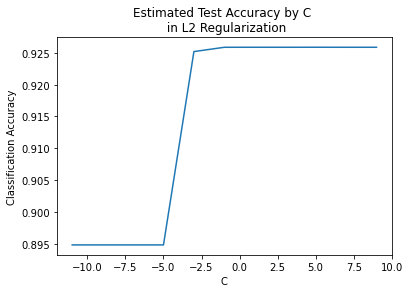

In [105]:
plt.plot(np.arange(-11,11,2),mean_accuracies)
plt.title("Estimated Test Accuracy by C \n in L2 Regularization")
plt.xlabel("C")
plt.ylabel("Classification Accuracy")
#plt.savefig('Classification Accuracy by C')

# Building Decision Tree Models